<a href="https://colab.research.google.com/github/98119833/98119833_Iris_Dataset/blob/main/98119833_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import sklearn

In [ ]:
from math import log2,sqrt 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing 
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

In [ ]:
from six import StringIO
from IPython.display import Image
import pydotplus
from tqdm.notebook import tqdm_notebook as tqdm

In [ ]:
column_names =['sepal length in cm', 'sepal width in cm', 'petal length in cm', 
                 'petal width in cm', "class"]
data = pd.read_csv("https://raw.githubusercontent.com/98119833/98119833_Iris_Dataset/main/Iris_Training_data.csv",header=None, names = column_names)
data.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class
0,6.0,3.0,4.8,1.8,Iris-virginica
1,5.1,3.8,1.5,0.3,Iris-setosa
2,4.9,2.4,3.3,1.0,Iris-versicolor
3,6.7,2.5,5.8,1.8,Iris-virginica
4,5.7,3.0,4.2,1.2,Iris-versicolor


In [ ]:
data.describe()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm
count,105.000000,105.000000,105.000000,105.000000
mean,5.904762,3.039048,3.955238,1.285714
std,0.844710,0.427537,1.748900,0.751208
min,4.400000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.400000
50%,5.900000,3.000000,4.500000,1.400000
75%,6.500000,3.300000,5.300000,1.900000
max,7.900000,4.400000,6.900000,2.500000


In [ ]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sepal length in cm  105 non-null    float64
 1   sepal width in cm   105 non-null    float64
 2   petal length in cm  105 non-null    float64
 3   petal width in cm   105 non-null    float64
 4   class               105 non-null    object 
dtypes: float64(4), object(1)
memory usage: 4.2+ KB


In [ ]:
print(f'dataset shape is{data.shape}')

dataset shape is(105, 5)


In [ ]:
def entropy(class_y):

    if len(class_y) <=1:
        return 0

    total_count = np.bincount(class_y)
    probabilities = total_count[np.nonzero(total_count)] / len(class_y)
    if len(probabilities) <= 1:
        return 0

    return -np.sum(probabilities * np.log(probabilities))/ np.log(len(probabilities))


In [ ]:
X=[0,0,0,1,1,1]
z=np.bincount(X)
print(z)
z[np.nonzero(z)]/len(X)

[3 3]


array([0.5, 0.5])

In [ ]:
def information_gain(previous_y, current_y):
  
    conditional_entropy=0
    for y in current_y:
        conditional_entropy += (entropy(y)*len(y)/len(previous_y))
    info_gain = entropy(previous_y) - conditional_entropy
    return info_gain


In [ ]:
#Test Case
test_class_y = [0,0,0,1,1,1,1,1]
print(entropy(test_class_y))

previous_y=[0,0,0,1,1,1]
current_y=[0,0],[1,1,1,0]
print(information_gain(previous_y,current_y))


0.954434002924965
0.4591479170272448


In [ ]:
def partition_classes(X, y, split_attribute, split_val):
    
    X = np.array(X)
    column_split = X[:,split_attribute]
    X_left = []
    y_right = []
    X_right =[]
    y_left = []

    counter=0

    if isinstance(split_val,str) == False:
        for i in column_split:
            if i <= split_val:
                X_left.append(X[counter])
                y_left.append(y[counter])
            else:
                X_right.append(X[counter])
                y_right.append(y[counter])
            counter+=1
         
    else:
        for i in column_split:
            if i == split_val:
                X_left.append(X[counter])
                y_left.append(y[counter])
            else:
                X_right.append(X[counter])
                y_right.append(y[counter])
            counter+=1;

    return X_left, X_right, y_left, y_right


In [ ]:
def find_best_split(X, y, split_attribute):


    best_info_gain = 0
    X = np.array(X)
    column_split = X[:,split_attribute]

    column_split = np.unique(column_split)
    best_split_val = column_split[0]

    for split_val in column_split:
        current_X_left, current_X_right, current_y_left, current_y_right = partition_classes(X, y, split_attribute, split_val)
        current_y = []
        current_y.append(current_y_left)
        current_y.append(current_y_right)

        current_info_gain = information_gain(y,current_y)
        if current_info_gain > best_info_gain:
            best_info_gain = current_info_gain 
            best_split_val = split_val

    return best_split_val, best_info_gain


In [ ]:
def find_best_feature(X, y):

    best_info_gain = 0
    best_feature = 0
    best_split_val = 0
    for feature_index in range(len(X[0])):
        current_best_split_val, current_best_info_gain = find_best_split(X, y, feature_index) 
        if current_best_info_gain>best_info_gain:
            best_info_gain = current_best_info_gain
            best_feature = feature_index
            best_split_val = current_best_split_val
    return best_feature, best_split_val


In [ ]:
class MyDecisionTree(object):
    def __init__(self, max_depth=None):

        self.tree = {}
        self.residual_tree = {}
        self.max_depth = max_depth

    def fit(self, X, y, depth):

        unique_labels=np.unique(y)
        if (len(unique_labels)==1) or (depth == max_depth):
            unique_labels, counts_unique_labels = np.unique(y, return_counts=True)
            index = counts_unique_labels.argmax()
            classification = unique_labels[index]
            return classification
         

        best_feat, best_split = find_best_feature(X, y)
        best_split, information_gain = find_best_split(X, y, best_feat)
        X_left, X_right, y_left, y_right = partition_classes(X, y, best_feat, best_split)

        if isinstance(best_split,str):
            question = "{} == {}".format(best_feat, best_split)
        else:
            question = "{} <= {}".format(best_feat, best_split)
        node = {question: []}

        depth+=1
        yes_answer = self.fit(X_left,y_left, depth)
        no_answer = self.fit(X_right, y_right, depth)

        if yes_answer == no_answer:
            node = yes_answer
        else:
            node[question].append(yes_answer)
            node[question].append(no_answer)
        self.tree = node
        return node
                                                    
    def predict(self, record,flag=1):
        if flag == 1:
            self.residual_tree = self.tree
        question = list(self.residual_tree.keys())[0]
        feature, comparison, value = question.split()

        if comparison == "==":
            if record[int(feature)] == value:
                answer = self.residual_tree[question][0]
            else:
                answer = self.residual_tree[question][1]
        elif comparison == "<=":
            if record[int(feature)] <= float(value):
                answer = self.residual_tree[question][0]
            else:
                answer = self.residual_tree[question][1]
            
            
        if not isinstance(answer, dict):
            return answer       
        else:
            self.residual_tree = answer
            return self.predict(record,0) 

In [ ]:
def DecisionTreeEvaluation(id3,X,y, verbose=False):

    y_predicted = []
    for record in X:
        y_predicted.append(id3.predict(record))
   
    results = [prediction == truth for prediction, truth in zip(y_predicted, y)]
    
    accuracy = float(results.count(True)) / float(len(results))
    if verbose:
        print("accuracy: %.4f" % accuracy)
    return accuracy 

In [ ]:
column_names =['sepal length in cm', 'sepal width in cm', 'petal length in cm', 
                 'petal width in cm', "class"]
df_test = pd.read_csv("https://raw.githubusercontent.com/98119833/98119833_Iris_Dataset/main/Iris_Test_data.csv", header = None, names = column_names)
df_test.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class
0,7.0,3.2,4.7,1.4,Iris-versicolor
1,5.6,3.0,4.1,1.3,Iris-versicolor
2,4.6,3.1,1.5,0.2,Iris-setosa
3,4.3,3.0,1.1,0.1,Iris-setosa
4,6.3,2.5,5.0,1.9,Iris-virginica


In [ ]:
df_train = pd.read_csv("https://raw.githubusercontent.com/98119833/98119833_Iris_Dataset/main/Iris_Training_data.csv", header = None, names = column_names)
column_names =['sepal length in cm', 'sepal width in cm', 'petal length in cm', 
                 'petal width in cm', "class"]
df_train.head()


,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class
0,6.0,3.0,4.8,1.8,Iris-virginica
1,5.1,3.8,1.5,0.3,Iris-setosa
2,4.9,2.4,3.3,1.0,Iris-versicolor
3,6.7,2.5,5.8,1.8,Iris-virginica
4,5.7,3.0,4.2,1.2,Iris-versicolor


In [ ]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
print(y_train.head())
label_enc = LabelEncoder()
y_train = label_enc.fit_transform(y_train)
print(y_train)

0     Iris-virginica
1        Iris-setosa
2    Iris-versicolor
3     Iris-virginica
4    Iris-versicolor
Name: class, dtype: object
[2 0 1 2 1 2 1 0 1 2 2 2 0 2 1 1 2 2 2 2 1 2 0 1 0 0 0 1 1 2 2 2 0 0 1 1 1
 1 1 1 0 1 2 2 0 1 2 2 2 1 0 2 0 1 0 1 2 0 2 2 0 2 2 0 1 2 1 1 0 0 0 2 1 1
 0 0 0 1 2 1 2 1 2 2 0 2 2 0 2 1 2 0 2 1 2 0 1 1 2 1 0 2 2 0 0]


In [ ]:
X_test = df_test.iloc[:,: -1]
y_test = df_test.iloc[:,-1]

label_enc = LabelEncoder()
y_test = label_enc.fit_transform(y_test)
y_test

array([1, 1, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 1, 2, 1, 1, 0,
       2])

In [ ]:
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
max_depth = 7
initial_depth = 0
id3_dt = MyDecisionTree(max_depth)
print("fitting the decision tree")
id3_dt.fit(X_train, y_train, initial_depth)
DecisionTreeEvaluation(id3_dt,X_test,y_test, True)

fitting the decision tree
accuracy: 0.9333


0.9333333333333333

In [ ]:
id3_dt.tree

{'2 <= 1.7': [0,
  {'2 <= 5.0': [{'3 <= 1.6': [{'1 <= 3.3': [{'2 <= 4.9': [1, 2]}, 0]},
      {'1 <= 2.8': [2, {'0 <= 5.9': [1, {'0 <= 6.0': [2, 1]}]}]}]},
    2]}]}

In [ ]:
clf = tree.DecisionTreeClassifier( criterion='entropy', max_depth = max_depth)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9777777777777777


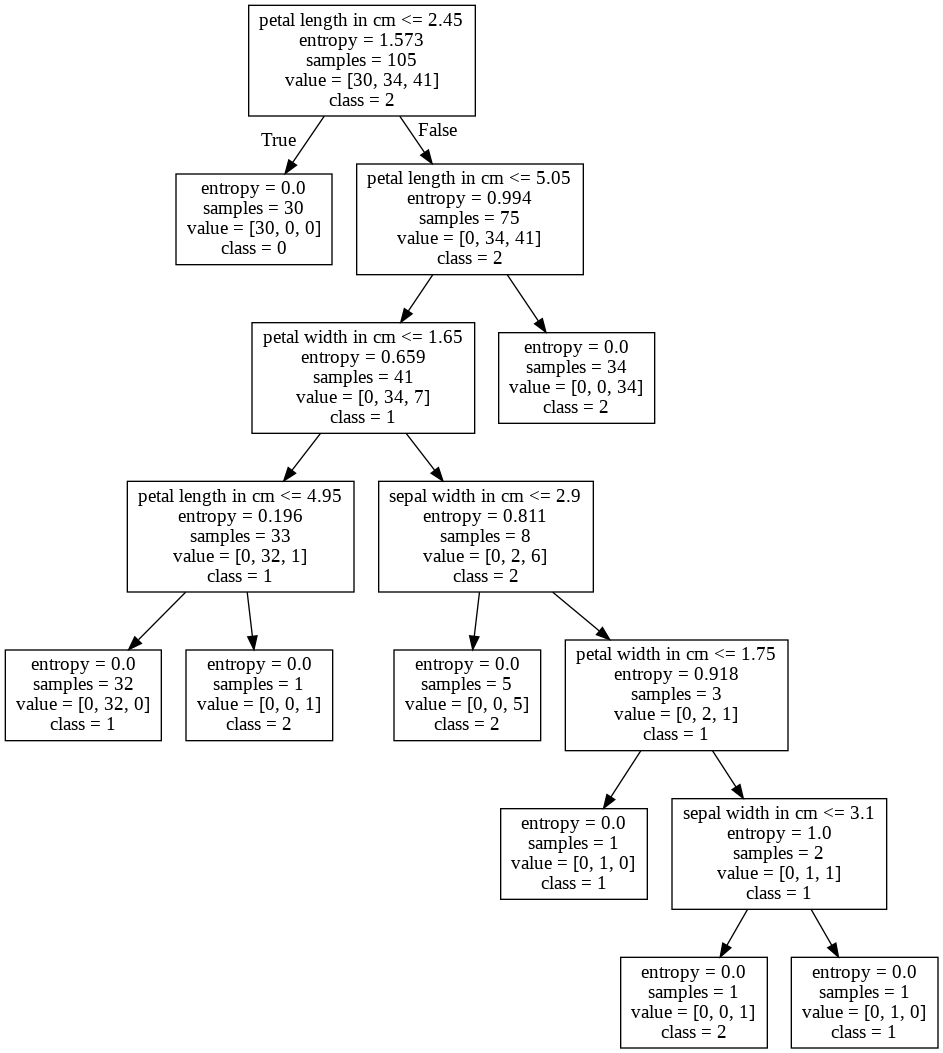

In [ ]:

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names = ('sepal length in cm', 'sepal width in cm', 'petal length in cm', 
                 'petal width in cm'),class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('Iris_tree.png')
Image(graph.create_png())